In [1]:
# mahalanobis_discriminative model

In [2]:
from collections import OrderedDict

import numpy as np
import torch as th
from torch import nn
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import cv2 
import pandas as pd
import math
from scipy.spatial import distance as mahal_distance

from skimage.util import random_noise
classes = np.array(['uCry', 'sCry', 'cCry', 'hCast', 'nhCast', 'sEC', 'nsEC', 'WBC', 'RBC'])
outlier_classes1 = np.array(['Artifact', 'Dirt', 'LD'])
outlier_classes2 = np.array(['blankurine', 'bubbles', 'cathair', 'condensation', 'dust', 'feces', 'fingerprint', 'humanhair',
                            'Lipids', 'Lotion', 'pollen', 'semifilled', 'void', 'wetslide', 'yeast'])
# Loading the pre-trained classifier

def conv_bn_relu(
        in_channels, out_channels,
        kernel_size=3, padding=None, stride=1,
        depthwise=False, normalization=True,
        activation=True, init_bn_zero=False):
    """
    Make a depthwise or normal convolution layer, 
    followed by batch normalization and an activation.
    """
    layers = []
    padding = kernel_size // 2 if padding is None else padding

    if depthwise and in_channels > 1:
        layers += [
            nn.Conv2d(in_channels, in_channels, bias=False,
                      kernel_size=kernel_size, stride=stride,
                      padding=padding, groups=in_channels),
            nn.Conv2d(in_channels, out_channels, 
                      bias=not normalization, kernel_size=1)
        ]
    else:
        layers.append(
            nn.Conv2d(in_channels, out_channels, bias=not normalization,
                      kernel_size=kernel_size, stride=stride,
                      padding=padding)
        )
    if normalization:
        bn = nn.BatchNorm2d(out_channels)
        if init_bn_zero:
            nn.init.zeros_(bn.weight)
        layers.append(bn)
    if activation:
        # TODO: parametrize activation
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

def depthwise_cnn_classifier(
    channels=[],
    strides=None,
    img_width=32,
    img_height=32,
    c_in=None,
    c_out=None,
):
    channels = channels[:]
    if c_in is not None:
        channels.insert(0, c_in)
    if c_out is not None:
        channels.append(c_out)

    if len(channels) < 2:
        raise ValueError("Not enough channels")

    layers = OrderedDict()
    number_convolutions = len(channels) - 2

    if strides is None:
        strides = [2] * number_convolutions

    out_width = img_width
    out_height = img_height

    for layer_index in range(number_convolutions):
        in_channels = channels[layer_index]
        out_channels = channels[layer_index + 1]
        layers["conv1" + str(layer_index)] = conv_bn_relu(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=strides[layer_index],
            depthwise=layer_index > 0,
            normalization=True,
            activation=True,
        )
        layers["conv2" + str(layer_index)] = conv_bn_relu(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            depthwise=True,
            normalization=True,
            activation=True,
        )

        out_width = out_width // strides[layer_index]
        out_height = out_height // strides[layer_index]

    layers["drop"] = nn.Dropout(p=0.2)
    layers["flatten"] = nn.Flatten()
    layers["final"] = nn.Linear(out_width * out_height * channels[-2], channels[-1])
    #layers["softmax"] = nn.Softmax(-1)

    return nn.Sequential(layers)



# load model
cnn = depthwise_cnn_classifier([32, 64, 128], c_in=1, c_out=9, img_width=32, img_height=32)
cnn.load_state_dict(th.load("/home/erdem/pickle/thomas_classifier/urine_classifier_uniform_32x32.pt"))
cnn.eval()  # IMPORTANT
cnn

Sequential(
  (conv10): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv20): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv11): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv21): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (1): Conv2d(64, 64, kernel_size=(1, 1),

In [3]:
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode

In [4]:
# Mahalanobis
# get empirical class means and covariances
def get_mean_covariance(f):
    means= []
    observations = []
    for cl in classes:
        print("in class", cl)
        cl_path = "/home/thomas/tmp/patches_urine_32_scaled/"+cl+"/"
        counter = 0
        temp_array = None
        
        for img_path in Path(cl_path).glob("*.png"):
            counter += 1
            image = th.from_numpy(plt.imread(img_path)).float()
            if counter == 1:
                temp_array = f(image[None, None, :, :] - 1).detach().view(-1).numpy()
                observations.append(f(image[None, None, :, :] - 1).detach().view(-1).numpy())
            else:
                temp_array += f(image[None, None, :, :] - 1).detach().view(-1).numpy()
                observations.append(f(image[None, None, :, :] - 1).detach().view(-1).numpy())
        means.append(temp_array/counter)
    
    V = np.cov(observations, rowvar=False)
    VM = np.matrix(V)
    
    return means, VM

# Returns the -mahal distance per class, max is better
def Mahal_distance(f, x, means, cov):
    np_output = f(x[None, None, :, :] - 1).detach().view(-1).numpy()
    
    mahal_distance_per_C = []
    for i in range(len(classes)):
        maha = mahal_distance.mahalanobis(np_output, means[i], cov)
        mahal_distance_per_C.append(maha)
        
    return mahal_distance_per_C

def test_mahala(f, means, covs, outlier_class, outlier_temp, perturb):
    covi = covs.I
    inlier_scores = []
    inlier_labels = []
    for cl in classes:
        print(cl)
        cl_path = "/home/thomas/tmp/patches_urine_32_scaled/"+cl+"/"
        for img_path in Path(cl_path).glob("*.png"):
            inlier_labels.append(1)
            image = th.from_numpy(plt.imread(img_path)).float()
            if perturb == 'gaussian':
                image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
            elif perturb == 's&p':
                image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
            mahal_dist_per_c = Mahal_distance(f, image, means, covi)
            temp_score = np.amax(mahal_dist_per_c)
            inlier_scores.append(temp_score)

    sns.scatterplot(data=inlier_scores)

    outlier_scores = []
    outlier_labels = []
    for cl in outlier_class:
        print(cl)
        cl_path = outlier_temp+cl+"/"
        for img_path in Path(cl_path).glob("*.png"):
            outlier_labels.append(0)
            image = th.from_numpy(plt.imread(img_path)).float()
            if perturb == 'gaussian':
                image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
            elif perturb == 's&p':
                image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
            mahal_dist_per_c = Mahal_distance(f, image, means, covi)
            temp_score = np.amax(mahal_dist_per_c)
            outlier_scores.append(temp_score)

    sns.scatterplot(data=outlier_scores)

    score_array = inlier_scores+outlier_scores
    label_array = inlier_labels+outlier_labels

    print(calc_metrics(score_array, label_array))

    plot_roc(score_array, label_array)
#     plot_pr(score_array, label_array)
#     plot_barcode(score_array, label_array)
def test_mahala_final(f, means, covs, perturb):
    covi = covs.I
    inlier_scores = []
    inlier_labels = []
    outlier_scores = []
    outlier_labels = []
    inlier_path = "/home/erdem/dataset/urine_test_32/inliers"
    outlier_path = "/home/erdem/dataset/urine_test_32/outliers"
    # Inliers
    for img_path in Path(inlier_path).glob("*.png"):
        inlier_labels.append(0)
        image = th.from_numpy(plt.imread(img_path)).float()
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        mahal_dist_per_c = Mahal_distance(f, image, means, covi)
        temp_score = np.amax(mahal_dist_per_c)
        inlier_scores.append(temp_score)
    
    # Outliers
    for img_path in Path(outlier_path).glob("*.png"):
        outlier_labels.append(1)
        image = th.from_numpy(plt.imread(img_path)).float()
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        mahal_dist_per_c = Mahal_distance(f, image, means, covi)
        temp_score = np.amax(mahal_dist_per_c)
        outlier_scores.append(temp_score)
    
    d_outliers = {"Mahalanobis Distance": outlier_scores, "outlier_labels": outlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    d_inliers = {"Mahalanobis Distance": inlier_scores, "inlier_labels": inlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    df1 = pd.DataFrame(data=d_inliers)
    df2 = pd.DataFrame(data=d_outliers)
    sns.scatterplot(data=df1, x="Index of Image Patches", y="Mahalanobis Distance")
    sns.scatterplot(data=df2, x="Index of Image Patches", y="Mahalanobis Distance")
    
    score_array = inlier_scores+outlier_scores
    label_array = inlier_labels+outlier_labels

    print(calc_metrics(score_array, label_array))

    plot_roc(score_array, label_array)
    plot_pr(score_array, label_array)
#     plot_barcode(score_array, label_array)

In [5]:
from copy import deepcopy
cnn_flattened = deepcopy(cnn)
del cnn_flattened[-1] # remove linear

image = th.from_numpy(plt.imread("/home/thomas/tmp/patches_contaminants_32_scaled/bubbles/Anvajo_bubbles1_100um_161_385_201_426.png")).float()

cnn_dropout = deepcopy(cnn_flattened)
del cnn_dropout[-1] # remove flatten

seq6 = deepcopy(cnn_dropout)
del seq6[-1] # remove dropout
del seq6[-1][-1] # remove last relu

seq5 = deepcopy(seq6)
del seq5[-1] # remove dropout
del seq5[-1][-1] # remove last relu

seq4 = deepcopy(seq5)
del seq4[-1] # remove dropout
del seq4[-1][-1] # remove last relu

seq3 = deepcopy(seq4)
del seq3[-1] # remove dropout
del seq3[-1][-1] # remove last relu

seq2 = deepcopy(seq3)
del seq2[-1] # remove dropout
del seq2[-1][-1] # remove last relu

seq1 = deepcopy(seq2)
del seq1[-1] # remove dropout
del seq1[-1][-1] # remove last relu

In [6]:
means, COV= get_mean_covariance(cnn_flattened)

in class uCry
in class sCry
in class cCry
in class hCast
in class nhCast
in class sEC
in class nsEC
in class WBC
in class RBC


In [24]:
COVI = COV.I

In [27]:
print(COVI)

[[ 2.32566422e+02 -2.40708589e+00 -3.95551527e+00 ... -4.07375306e+00
   7.24587469e-03  2.69562596e+00]
 [-2.40708589e+00  1.38666692e+02 -1.36932212e+01 ... -1.89785841e-01
   2.72072494e-01  6.86707867e-01]
 [-3.95551527e+00 -1.36932212e+01  1.18830106e+02 ...  9.21058645e-01
   3.67939063e+00  1.30106420e-01]
 ...
 [-4.07375306e+00 -1.89785841e-01  9.21058645e-01 ...  1.08638292e+02
  -1.53276818e+01 -1.25045231e+00]
 [ 7.24587469e-03  2.72072494e-01  3.67939063e+00 ... -1.53276818e+01
   1.59575692e+02 -2.11022348e+01]
 [ 2.69562596e+00  6.86707867e-01  1.30106420e-01 ... -1.25045231e+00
  -2.11022348e+01  1.22047666e+02]]


{'fpr_at_95_tpr': 0.13836477987421383, 'detection_error': 0.09355345911949688, 'auroc': 0.9690627348601717, 'aupr_out': 0.9660618733192833, 'aupr_in': 0.9701781057238017}


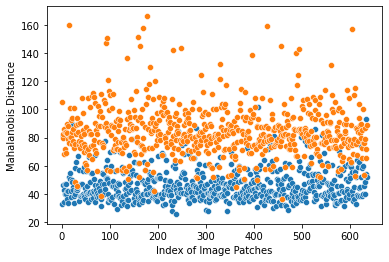

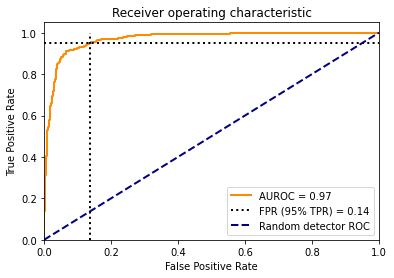

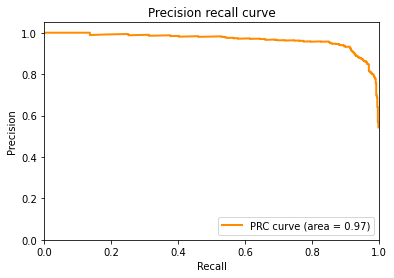

In [7]:
# cnn without the linear last layer
test_mahala_final(cnn_flattened, means, COV, perturb = None)

{'fpr_at_95_tpr': 0.839622641509434, 'detection_error': 0.44418238993710696, 'auroc': 0.7883464855029468, 'aupr_out': 0.807450405884216, 'aupr_in': 0.7279348790857116}


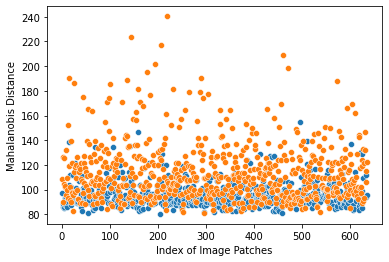

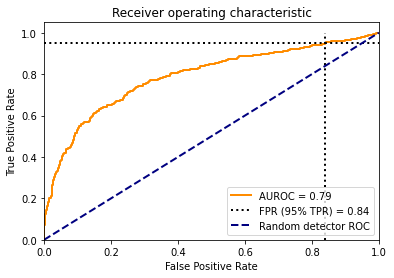

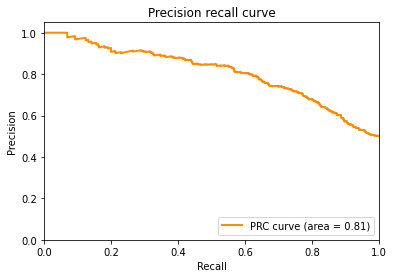

In [35]:
# cnn without the linear last layer
test_mahala_final(cnn_flattened, means, COV, perturb = 'gaussian')

{'fpr_at_95_tpr': 0.9229559748427673, 'detection_error': 0.4811320754716981, 'auroc': 0.6455515011273288, 'aupr_out': 0.7178987962706608, 'aupr_in': 0.5844786450127037}


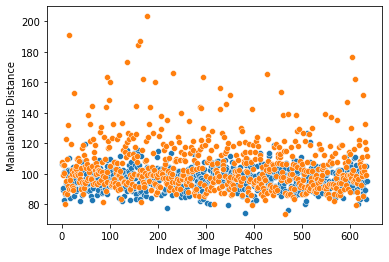

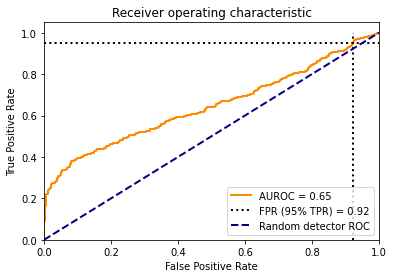

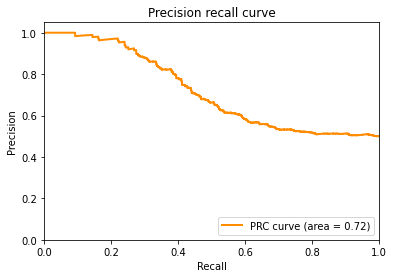

In [36]:
# cnn without the linear last layer
test_mahala_final(cnn_flattened, means, COV, perturb = 's&p')

in class uCry
in class sCry
in class cCry
in class hCast
in class nhCast
in class sEC
in class nsEC
in class WBC
in class RBC
uCry
sCry
cCry
hCast
nhCast
sEC
nsEC
WBC
RBC
Artifact
Dirt
LD
{'fpr_at_95_tpr': 0.07964601769911504, 'detection_error': 0.002215930075095366, 'auroc': 0.971931103819341, 'aupr_out': 0.999472528082346, 'aupr_in': 0.9115634193966702}


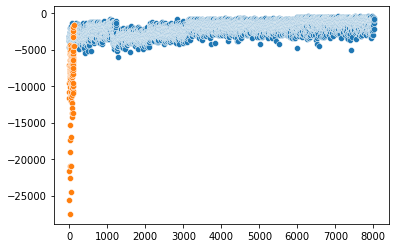

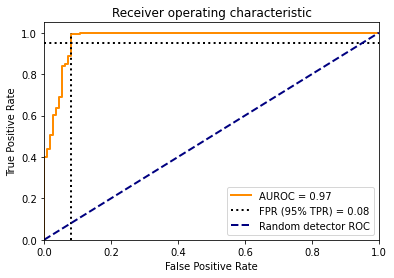

In [7]:
means, COV= get_mean_covariance(cnn_flattened)
# cnn without the linear last layer
test_mahala(cnn_flattened, means, COV, outlier_classes1, "/home/thomas/tmp/patches_urine_32_scaled/", perturb = None)

In [8]:
import pandas as pd
COVI = COV.I

Artifact
Dirt
LD


<AxesSubplot:xlabel='outlier_labels', ylabel='outlier_scores'>

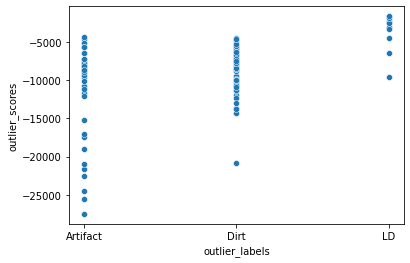

In [9]:
outlier_temp = "/home/thomas/tmp/patches_urine_32_scaled/"
perturb = None
outlier_labels = []
outlier_scores = []
outlier_path = []
for cl in outlier_classes1:
    print(cl)
    cl_path = outlier_temp+cl+"/"
    
    for img_path in Path(cl_path).glob("*.png"):
        outlier_path.append(img_path)
        outlier_labels.append(cl)
        image = th.from_numpy(plt.imread(img_path)).float()
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
        mahal_dist_per_c = Mahal_distance(cnn_flattened, image, means, COVI)
        temp_score = np.amax(mahal_dist_per_c)
        outlier_scores.append(temp_score)
d = {"outlier_scores": outlier_scores, "outlier_labels": outlier_labels, "outlier_path": outlier_path}

df = pd.DataFrame(data=d)
sns.scatterplot(data=df, x = "outlier_labels", y="outlier_scores")

uCry
sCry
cCry
hCast
nhCast
sEC
nsEC
WBC
RBC


<AxesSubplot:xlabel='outlier_labels', ylabel='outlier_scores'>

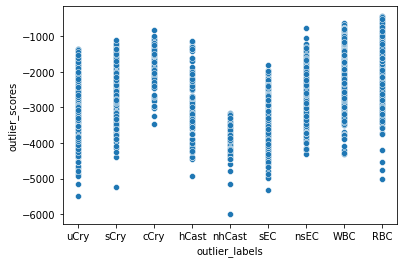

In [10]:
outlier_temp = "/home/thomas/tmp/patches_urine_32_scaled/"
perturb = None
outlier_labels = []
outlier_scores = []
outlier_path = []
for cl in classes:
    print(cl)
    cl_path = outlier_temp+cl+"/"
    
    for img_path in Path(cl_path).glob("*.png"):
        outlier_path.append(img_path)
        outlier_labels.append(cl)
        image = th.from_numpy(plt.imread(img_path)).float()
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
        mahal_dist_per_c = Mahal_distance(cnn_flattened, image, means, COVI)
        temp_score = np.amax(mahal_dist_per_c)
        outlier_scores.append(temp_score)
d = {"outlier_scores": outlier_scores, "outlier_labels": outlier_labels, "outlier_path": outlier_path}

df2 = pd.DataFrame(data=d)
sns.scatterplot(data=df2, x = "outlier_labels", y="outlier_scores")

blankurine
bubbles
cathair
condensation
dust
feces
fingerprint
humanhair
Lipids
Lotion
pollen
semifilled
void
wetslide
yeast


<AxesSubplot:xlabel='outlier_labels', ylabel='outlier_scores'>

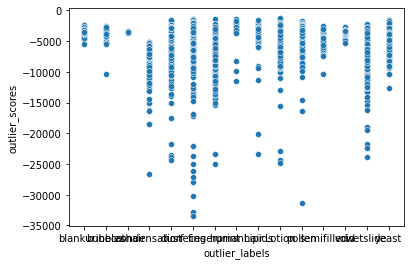

In [101]:
outlier_temp = "/home/thomas/tmp/patches_contaminants_32_scaled/"
perturb = None
outlier_labels = []
outlier_scores = []
outlier_path = []
for cl in outlier_classes2:
    print(cl)
    cl_path = outlier_temp+cl+"/"
    
    for img_path in Path(cl_path).glob("*.png"):
        outlier_path.append(img_path)
        outlier_labels.append(cl)
        image = th.from_numpy(plt.imread(img_path)).float()
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
        mahal_dist_per_c = Mahal_distance(cnn_flattened, image, means, COVI)
        temp_score = np.amax(mahal_dist_per_c)
        outlier_scores.append(temp_score)
d = {"outlier_scores": outlier_scores, "outlier_labels": outlier_labels, "outlier_path": outlier_path}

df4 = pd.DataFrame(data=d)
sns.scatterplot(data=df4, x = "outlier_labels", y="outlier_scores")

<AxesSubplot:xlabel='outlier_labels', ylabel='outlier_scores'>

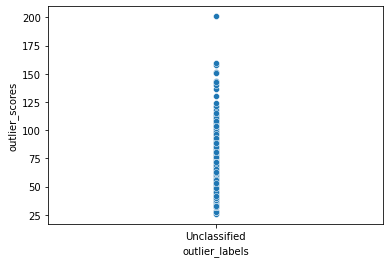

In [38]:
cl_path = "/home/thomas/tmp/patches_urine_32_scaled/Unclassified"
perturb = None
outlier_labels = []
outlier_scores = []
outlier_path = []
cl = "Unclassified"
COVI = COV.I
for img_path in Path(cl_path).glob("*.png"):
    outlier_path.append(img_path)
    outlier_labels.append(cl)
    image = th.from_numpy(plt.imread(img_path)).float()
    if perturb == 'gaussian':
        image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
    elif perturb == 's&p':
        image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
    mahal_dist_per_c = Mahal_distance(cnn_flattened, image, means, COVI)
    temp_score = np.amax(mahal_dist_per_c)
    outlier_scores.append(temp_score)
d = {"outlier_scores": outlier_scores, "outlier_labels": outlier_labels, "outlier_path": outlier_path}

df3 = pd.DataFrame(data=d)
sns.scatterplot(data=df3, x = "outlier_labels", y="outlier_scores")

In [39]:
# sorted_outliers1 = df.sort_values(by=['outlier_scores'])
# sorted_outliers2 = df4.sort_values(by=['outlier_scores'])
# sorted_inliers = df2.sort_values(by=['outlier_scores'])
sorted_unclassified = df3.sort_values(by=['outlier_scores'])

In [88]:
index = 0
# index: 717 and after is inlier
for a in sorted_unclassified['outlier_scores']:
    print(index, a)
    index += 1

0 -40219.3928233936
1 -25244.915363006017
2 -24727.987536510096
3 -22893.170785527276
4 -22592.03630541339
5 -20424.33362799262
6 -20258.965947069806
7 -20062.162619643175
8 -19482.936620741697
9 -18578.96712459878
10 -16905.055952684266
11 -15317.12391996274
12 -14731.22731353155
13 -14446.96956122007
14 -13856.234117461245
15 -13129.535086540207
16 -12947.195046068518
17 -12809.564262669985
18 -12745.255834154166
19 -12646.368560619303
20 -12627.029797618672
21 -12543.676049535135
22 -12218.743430633036
23 -12188.178608128708
24 -12116.426585027475
25 -12085.357174898558
26 -12010.722474452496
27 -11749.791793980767
28 -11713.893854102043
29 -11703.717510836514
30 -11697.903506407702
31 -11672.331365147962
32 -11647.583536204387
33 -11639.4299941767
34 -11604.32541865503
35 -11592.667924143927
36 -11591.101340283312
37 -11580.125099614217
38 -11574.6442444102
39 -11407.852301774386
40 -11401.864355451457
41 -11392.887855823481
42 -11334.097080936108
43 -11149.296371828728
44 -11029.0

1513 -2916.44522465085
1514 -2916.0136875175463
1515 -2912.72873921762
1516 -2912.3276737849833
1517 -2911.3175801794564
1518 -2908.404702044922
1519 -2908.2692631034174
1520 -2907.435027409896
1521 -2907.165089057012
1522 -2906.574595053338
1523 -2905.81298818241
1524 -2900.2251966986655
1525 -2898.5754035106943
1526 -2891.9309150406807
1527 -2891.1995522786465
1528 -2883.118129868016
1529 -2881.7433082835582
1530 -2881.5097732641025
1531 -2880.1442329399733
1532 -2879.089754740333
1533 -2876.2360445568493
1534 -2874.5250826826928
1535 -2868.44666221392
1536 -2864.8691654156737
1537 -2864.618618839714
1538 -2860.174130002929
1539 -2859.8733460446438
1540 -2851.939122547509
1541 -2851.501316474066
1542 -2849.9667621215253
1543 -2841.6089775252876
1544 -2836.598780031428
1545 -2827.585640350478
1546 -2827.415405756835
1547 -2827.218083600377
1548 -2826.650992914165
1549 -2821.341155470492
1550 -2820.1045210505354
1551 -2818.4912407372917
1552 -2817.333108876553
1553 -2816.1386267682637


In [40]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
%matplotlib inline
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [41]:
unclassified_imgs = []
for path in sorted_unclassified["outlier_path"]:
    unclassified_imgs.append(read_image(str(path)))